MNIST dataset loaded successfully.

Data preprocessing completed.

Model created.

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 - 1s - 375ms/step - accuracy: 0.0900 - loss: 2.2967
Epoch 2/3
4/4 - 0s - 33ms/step - accuracy: 0.3800 - loss: 2.1004
Epoch 3/3
4/4 - 0s - 34ms/step - accuracy: 0.6200 - loss: 1.9062
Initial model training completed.

Standard model created.

Epoch 1/3
4/4 - 1s - 373ms/step - accuracy: 0.3100 - loss: 2.2585
Epoch 2/3
4/4 - 0s - 34ms/step - accuracy: 0.3400 - loss: 2.0753
Epoch 3/3
4/4 - 0s - 34ms/step - accuracy: 0.4300 - loss: 1.8585
Initial standard model training completed.

Starting comparaison.

Starting Active Learning iteration 1
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
Fitting model :
4/4 - 0s - 48ms/step - accuracy: 0.6000 - loss: 1.6611
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Fitting standard model :
4/4 - 0s - 29ms/step - accuracy: 0.3800 - loss: 1.8152
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Iteration 1 - Active Learning Accuracy_score: 0.5433 | Standard Accuracy_score: 0.5441

Starting Active Learning iteration 2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step
Fitting

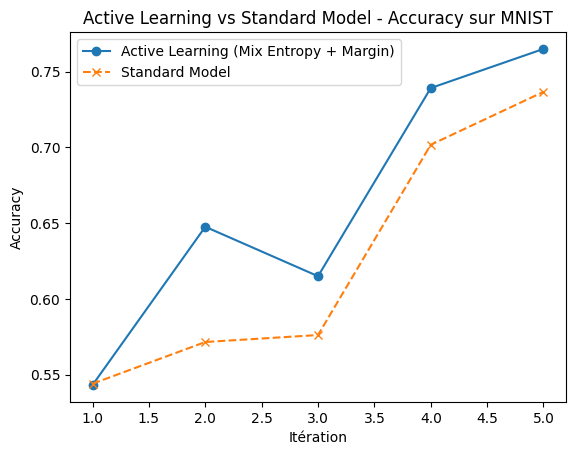

Learning curves displayed.



In [ ]:
from IPython import get_ipython
from IPython.display import display
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score
import random

# Load the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("MNIST dataset loaded successfully \n")

# Preprocess the data
x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0
print("Data preprocessing completed.\n")

# Define a simple CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function for margin sampling
def calculate_margin_sampling(predictions):
    # sort all the predictions to get the highest values at the end of the array
    sorted_preds = np.sort(predictions, axis=1)

    # calculate the margin by doing the soustraction of the two highest prediction of the model on the same image
    return sorted_preds[:, -1] - sorted_preds[:, -2]

# Function to select the most uncertain data
def select_uncertain_data(model, x_pool, n_samples=10):
    predictions = model.predict(x_pool)
    margin = calculate_margin_sampling(predictions)

    # Select n_samples indices that represents the lowest values of margin (the n_samples ones)
    uncertain_indices = margin.argsort()[:n_samples]
    return x_pool[uncertain_indices], y_pool[uncertain_indices], uncertain_indices

# Initialize the model
model = create_model()
print("Model created.\n")

# Select an initial training subset (100 images)
initial_indices = random.sample(range(0, len(x_train)), 100)
x_train_initial = x_train[initial_indices]
y_train_initial = y_train[initial_indices]
model.fit(x_train_initial, y_train_initial, epochs=3, batch_size=32, verbose=2)  # Initial training
print("Initial model training completed.\n")

# Create the standard model for comparison
model_standard = create_model()
print("Standard model created.\n")

# Train the standard model on an initial random subset
standard_initial_indices = random.sample(range(0, len(x_train)), 100)
x_train_random = x_train[standard_initial_indices]
y_train_random = y_train[standard_initial_indices]
model_standard.fit(x_train_random, y_train_random, epochs=3, batch_size=32, verbose=2)
print("Initial standard model training completed.\n")

# Variables to track performance
accuracy_history_active = []
accuracy_history_standard = []

# Training loop
n_iterations = 5
n_samples_per_iteration = 10
x_pool = x_train  # The remaining data pool (all except the initial set)
y_pool = y_train

print("🔄 Starting comparaison... \n")
for i in range(n_iterations):
    print(f"Starting Active Learning iteration {i+1}")
    # Select the most uncertain data (by mixed strategy)
    x_uncertain, y_uncertain, uncertain_indices = select_uncertain_data(model, x_pool, n_samples=n_samples_per_iteration)

    # Add this data to the training set
    x_train_initial = np.concatenate([x_train_initial, x_uncertain], axis=0)
    y_train_initial = np.concatenate([y_train_initial, y_uncertain], axis=0)

    # Train with the new data
    print("Fitting model :")
    model.fit(x_train_initial, y_train_initial, epochs=1, batch_size=32, verbose=2)

    # Evaluate the active model after each iteration
    predictions_active = model.predict(x_test)
    accuracy_active = accuracy_score(y_test, np.argmax(predictions_active, axis=1))
    accuracy_history_active.append(accuracy_active)

    # Evaluate the standard model after each iteration (it is retrained only with a random batch)
    print("Fitting standard model :")
    standard_initial_indices = random.sample(range(0, len(x_train)), 100)
    x_train_random = x_train[standard_initial_indices]
    y_train_random = y_train[standard_initial_indices]
    model_standard.fit(x_train_random, y_train_random, epochs=1, batch_size=32, verbose=2)
    predictions_standard = model_standard.predict(x_test)
    accuracy_standard = accuracy_score(y_test, np.argmax(predictions_standard, axis=1))
    accuracy_history_standard.append(accuracy_standard)

    print(f"Iteration {i+1} - Active Learning Accuracy_score: {accuracy_active:.4f} | Standard Accuracy_score: {accuracy_standard:.4f}\n")

print("Model successfully trained! \n")

# Display the learning curves
plt.plot(range(1, n_iterations + 1), accuracy_history_active, label="Active Learning (Mix Entropy + Margin)", marker='o')
plt.plot(range(1, n_iterations + 1), accuracy_history_standard, label="Standard Model", linestyle='--', marker='x')
plt.title('Active Learning vs Standard Model - Accuracy on MNIST')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("✅ Learning curves displayed.\n")